# Synthetic Chest X-Ray Image Generation with PGGAN
In this notebook, we will demonstrate the functionality of ``Scheduler`` which enables advanced training schemes such as a progressive training method as described in [Karras et al.](https://arxiv.org/pdf/1710.10196.pdf). 
We will train a PGGAN to produce high resolution synthetic frontal chest X-ray images where both the generator and the discriminator grows from $4\times4$ to $1024\times1024$.


Stably training a GAN to produce realistic high resolution synthetic images is challenging.
The discriminator can easily tell apart real images from generated images in the high resolution setting.
This leads to instability in the training.

### Progressive Growing Strategy
[Karras et al.](https://arxiv.org/pdf/1710.10196.pdf) propose a training scheme in which both the generator and the discriminator progressively grow from a low resolution to a high resolution.
Both networks first start out training based on images of $4\times4$ as illustrated below.
![4x4](./Figure/pggan_4x4.png)
Then, both networks progress from $4\times4$ to $8\times8$ by an adding additional block that contains a couple of convolutional layers.
![8x8](./Figure/pggan_8x8.png)
Both the generator and the discriminator progressively grow until reaching the desired resolution of $1024\times 1024$.
![1024x1024](./Figure/pggan_1024x1024.png)
*Image Credit: [Presentation slide](https://drive.google.com/open?id=1jYlrX4DgTs2VAfRcyl3pcNI4ONkBg3-g)*

### Smooth Transition between Resolutions
However, when growing the networks, the new blocks are slowly faded into the networks in order to smoothly transition between different resolutions.
For example, when growing the generator from $16\times16$ to $32\times32$, the newly added block of $32\times32$ is slowly faded into the already well trained $16\times16$ network by linearly increasing $\alpha$ from $0$ to $1$.
Once the network is fully transitioned to $32\times32$, the network is trained on a bit further to stabilize before growing to $64\times64$.
![grow](./Figure/pggan_smooth_grow.png)
*Image Credit: [PGGAN Paper](https://arxiv.org/pdf/1710.10196.pdf)*

With this progressive training strategy, PGGAN has achieved the state-of-the-art in producing synthetic images of high fidelity.

## Problem Setting
In this PGGAN example, we decide the following:
* 560K images will be used when transitioning from a lower resolution to a higher resolution.
* 560K images will be used when stabilizing the fully transitioned network.
* Initial resolution will be $4\times4$.
* Final resolution will be $1024\times1024$.

The number of images for both transitioning and stabilizing is equivalent to 5 epochs; the networks would smoothly grow over 5 epochs and would stabilize for 5 epochs.
This yields the following schedule of growing both networks:

* Until $4^{th}$ epoch: train $4\times4$ resolution
* From $5^{th}$ epoch to $9^{th}$ epoch: transition from $4\times4$ to $8\times8$
* From $10^{th}$ epoch to $14^{th}$ epoch: stabilize $8\times8$
* From $15^{th}$ epoch to $19^{th}$ epoch: transition from $8\times8$ to $16\times16$
* From $20^{th}$ epoch to $24^{th}$ epoch: stabilize $16\times16$

$\cdots$

* From $80^{th}$ epoch to $84^{th}$ epoch: stabilize $1024\times1024$


In [1]:
import os
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend

import fastestimator as fe

## Defining Input Pipeline

First, we need to download chest frontal X-ray dataset from the National Institute of Health (NIH); the dataset has over 112,000 images of $1024\times1024$. 
We use ``fastestimator.dataset.nih_chestxray.load_data`` to download images and create a csv file that contains relative paths to the training images. 
The parent path to the images returned in ``data_path`` .
A detailed description of the dataset is available [here](https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest-publicly-available-chest-x-ray-datasets-scientific-community).

### Note: Please make sure to have a stable internet connection when downloading the dataset for the first time since the size of the dataset is over 40GB.

In [2]:
from fastestimator.dataset.nih_chestxray import load_data
train_csv, data_path = load_data()

We will create two instances of ``RecordWriter`` objects to create two sets of tfrecords to use throughout the training.
``writer_128`` would contain training images of $128 \times 128$ to be used for the early phase of the training, and ``writer_1024`` would contain training images of $1024 \times 1024$ to be used for the later phase of the training.

In [3]:
from fastestimator.op.numpyop import ImageReader
from fastestimator.op.numpyop import Resize as ResizeRecord
from fastestimator.util.record_writer import RecordWriter

imreader = ImageReader(inputs="x", parent_path=data_path, grey_scale=True)

writer_128 = RecordWriter(save_dir=os.path.join(data_path, "tfrecord_128"),
                          train_data=train_csv,
                          ops=[imreader, ResizeRecord(target_size=(128, 128), outputs="x")])

writer_1024 = RecordWriter(save_dir=os.path.join(data_path, "tfrecord_1024"),
                           train_data=train_csv,
                           ops=[imreader, ResizeRecord(target_size=(1024, 1024), outputs="x")])

We need to define the following two custom ``TensorOp`` to process input images prior to feeding them to the network.
* ``Rescale`` operation to rescale pixels values from $[0, 255]$ to $[-1, 1]$.
* ``CreateLowRes`` operation to create images that are downsampled by a factor of 2 and upsampled by a factor of 2. The resulting images will be used for smooth transitioning between different resolutions.

In [4]:
from fastestimator.op import TensorOp

class Rescale(TensorOp):
    """Scale image values from uint8 to float32 between -1 and 1."""
    def forward(self, data, state):
        data = tf.cast(data, tf.float32)
        data = (data - 127.5) / 127.5
        return data

class CreateLowRes(TensorOp):
    def forward(self, data, state):
        data_shape = tf.shape(data)
        height = data_shape[0]
        width = data_shape[1]
        data = tf.image.resize(data, (height / 2, width / 2))
        data = tf.image.resize(data, (height, width))
        return data


The resolution of images change at epoch $0$, $5$, $15$, $25$, $35$, $45$, $55$, and $65$ throughout the training.
We can accomplish this using ``Scheduler`` which takes a dictionary as an input to express which operation (value) to perform at which epoch (key). Therefore, we specify to perform ``Resize`` operation to change the image resolution at those epoch. We resize images of $128\times128$ from the first set of tfrecords for the early training. Then, we resize $1024\times1024$ images for the later training.

In addition, we wil define another ``Scheduler`` to denote how we change the batch size alongside the image resolution. 
The batch size will progressively decrease as the resolution of image grows; the batch size will decrease from $128$ for $4\times4$ images to $1$ for $1024\times1024$.
Note that the batch size we specify here is the batch size per device. Therefore, the global batch size for $1024\times1024$ for 4 gpu machine will be $4$ whereas it will be $8$ for 8 gpu machine.

In [5]:
from fastestimator.schedule import Scheduler
from fastestimator.op.tensorop import Resize
# resize ops
resize_scheduler_128 = Scheduler({
    0: Resize(inputs="x", size=(4, 4), outputs="x"),
    5: Resize(inputs="x", size=(8, 8), outputs="x"),
    15: Resize(inputs="x", size=(16, 16), outputs="x"),
    25: Resize(inputs="x", size=(32, 32), outputs="x"),
    35: Resize(inputs="x", size=(64, 64), outputs="x"),
    45: None
})
resize_scheduler_1024 = Scheduler({
    55: Resize(inputs="x", size=(256, 256), outputs="x"),
    65: Resize(inputs="x", size=(512, 512), outputs="x"),
    75: None
})

# We create a scheduler for batch_size with the epochs at which it will change and corresponding values.
batchsize_scheduler_128 = Scheduler({0: 128, 5: 64, 15: 32, 25: 16, 35: 8, 45: 4})
batchsize_scheduler_1024 = Scheduler({55: 4, 65: 2, 75: 1})

We will define two instances of ``Pipeline`` for each ``RecordWriter`` objects.
Each ``Pipeline`` will perform the following operations:
* Resize train images according to ``Scheduler`` defined above
* Create lower resolution version of images
* Rescale resized image
* Rescale lower resolution image

Then, we create another ``Scheduler`` to control which tfrecords to use throughout the training.

In [6]:
lowres_op = CreateLowRes(inputs="x", outputs="x_lowres")
rescale_x = Rescale(inputs="x", outputs="x")
rescale_lowres = Rescale(inputs="x_lowres", outputs="x_lowres")

pipeline_128 = fe.Pipeline(batch_size=batchsize_scheduler_128,
                           data=writer_128,
                           ops=[resize_scheduler_128, lowres_op, rescale_x, rescale_lowres])
pipeline_1024 = fe.Pipeline(batch_size=batchsize_scheduler_1024,
                            data=writer_1024,
                            ops=[resize_scheduler_1024, lowres_op, rescale_x, rescale_lowres])

pipeline_scheduler = Scheduler({0: pipeline_128, 55: pipeline_1024})

Let's visualize how ``Pipeline``s change image resolutions at different epochs we specified in ``Scheduler``.
We provide ``show_results`` methods to visaulize the resulting images of ``Pipeline``.
In order to correctly visualize the output of ``Pipeline``, we need to provide epoch numbers to ``show_results`` 

FastEstimator: Reading non-empty directory: /root/fastestimator_data/NIH_Chestxray/tfrecord_128
FastEstimator: Found 112120 examples for train in /root/fastestimator_data/NIH_Chestxray/tfrecord_128/train_summary0.json
FastEstimator: Reading non-empty directory: /root/fastestimator_data/NIH_Chestxray/tfrecord_1024
FastEstimator: Found 112120 examples for train in /root/fastestimator_data/NIH_Chestxray/tfrecord_1024/train_summary0.json


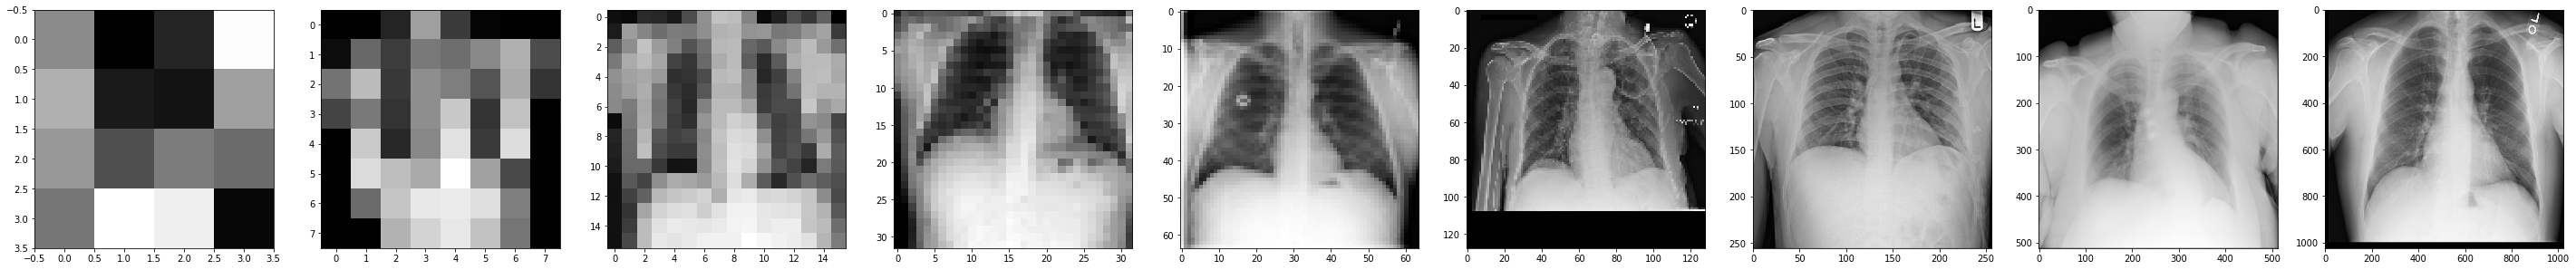

In [7]:
def display_pipeline_result(pipeline, epoch, reuse, batch_idx=0, img_key="x"):
    batch = pipeline.show_results(current_epoch=epoch, reuse=reuse)[0]
    img = batch[img_key][batch_idx].numpy()
    img = (img + 1) * 0.5    
    return img[..., 0]

# Visualizing pipeline_128
batch_idx = 0
epochs_128 = [0, 5, 15, 25, 35, 45]

plt.figure(figsize=(50,50))
for i, epoch in enumerate(epochs_128):
    img_128 = display_pipeline_result(pipeline_128, epoch, epoch != epochs_128[-1])
    plt.subplot(1, 9, i+1)
    plt.imshow(img_128, cmap='gray')

# Visualizing pipeline_1024
epochs_1024 = [55, 65, 75]
for i, epoch in enumerate(epochs_1024):
    img_1024 = display_pipeline_result(pipeline_1024, epoch, epoch != epochs_1024[-1])
    plt.subplot(1, 9, i+7)
    plt.imshow(img_1024, cmap='gray')    

## Defining Network
### Defining the generator and the discriminator
To express the progressive growing of networks, we return a list of models that progressively grow from $4 \times 4$ to $1024 \times 1024$ such that $i^{th}$ model in the list is the superset previous models.
We define a ``tf.Variable`` to allow models to grow smoothly.
``fe.build`` bundles each model, optimizer, the name of the model, and the associated loss name.

In [8]:
from fastestimator.architecture.pggan import build_G, build_D
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.0, beta_2=0.99, epsilon=1e-8)

fade_in_alpha = tf.Variable(initial_value=1.0, dtype='float32', trainable=False)

d2, d3, d4, d5, d6, d7, d8, d9, d10 = fe.build(
    model_def=lambda: build_D(fade_in_alpha=fade_in_alpha, target_resolution=10, num_channels=1),
    model_name=["d2", "d3", "d4", "d5", "d6", "d7", "d8", "d9", "d10"],
    optimizer=[optimizer]*9,
    loss_name=["dloss"]*9)

g2, g3, g4, g5, g6, g7, g8, g9, g10, G = fe.build(
    model_def=lambda: build_G(fade_in_alpha=fade_in_alpha, target_resolution=10, num_channels=1),
    model_name=["g2", "g3", "g4", "g5", "g6", "g7", "g8", "g9", "g10", "G"],
    optimizer=[optimizer]*10,
    loss_name=["gloss"]*10)

We need to define the following ``TensorOp``:
* ``RandomInput`` to produce random variables drawn from  $\mathcal{N}(0,\,1)$
* ``ImageBlender`` to blend real images of $2^{i} \times 2^{i}$ and $2^{i-1} \times 2^{i-1}$ to allow smooth transition when growing from $2^{i-1} \times 2^{i-1}$ to $2^{i} \times 2^{i}$
* ``Interpolate`` to interpolate between real images and generated images
* ``GradientPenalty`` to compute the gradient penalty using the result of the previous TensorOp ``Interpolate``

In [9]:
class RandomInput(TensorOp):
    def forward(self, data, state):
        latent_dim = data
        batch_size = state["local_batch_size"]
        random_vector = tf.random.normal([batch_size, latent_dim])
        return random_vector


class ImageBlender(TensorOp):
    def __init__(self, alpha, inputs=None, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.alpha = alpha

    def forward(self, data, state):
        image, image_lowres = data
        new_img = self.alpha * image + (1 - self.alpha) * image_lowres
        return new_img


class Interpolate(TensorOp):
    def forward(self, data, state):
        fake, real = data
        batch_size = state["local_batch_size"]
        coeff = tf.random.uniform(shape=[batch_size, 1, 1, 1], minval=0.0, maxval=1.0, dtype=tf.float32)
        return real + (fake - real) * coeff


class GradientPenalty(TensorOp):
    def __init__(self, inputs, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)

    def forward(self, data, state):
        x_interp, interp_score = data
        interp_score = tf.reshape(interp_score, [-1])
        tape = state['tape']
        gradient_x_interp = tape.gradient(tf.reduce_sum(interp_score), x_interp)
        grad_l2 = tf.math.sqrt(tf.reduce_sum(tf.math.square(gradient_x_interp), axis=[1, 2, 3]))
        gp = tf.math.square(grad_l2 - 1.0)
        return gp

We are now ready to define loss functions for the genrator and the discriminator.
The loss functions are modified version of the [WGAN-GP](https://arxiv.org/pdf/1704.00028.pdf); the discriminator's loss function has an additional term to penalize the discriminator's output on real images deviating too much from 0.

In [10]:
from fastestimator.op.tensorop import Loss

class GLoss(Loss):
    def forward(self, data, state):
        return -data


class DLoss(Loss):
    """Compute discriminator loss."""
    def __init__(self, inputs, outputs=None, mode=None, wgan_lambda=10, wgan_epsilon=0.001):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.wgan_lambda = wgan_lambda
        self.wgan_epsilon = wgan_epsilon

    def forward(self, data, state):
        real_score, fake_score, gp = data
        loss = fake_score - real_score + self.wgan_lambda * gp + self.wgan_epsilon * tf.math.square(real_score)
        return loss


With the losses defined, we need to specify the forward pass of the networks.
We utilize ``Scheduler`` to progressively train different generators and the discriminators to express progressive growing of the networks.

In [11]:
from fastestimator.op.tensorop import ModelOp

g_scheduler = Scheduler({
    0: ModelOp(model=g2, outputs="x_fake"),
    5: ModelOp(model=g3, outputs="x_fake"),
    15: ModelOp(model=g4, outputs="x_fake"),
    25: ModelOp(model=g5, outputs="x_fake"),
    35: ModelOp(model=g6, outputs="x_fake"),
    45: ModelOp(model=g7, outputs="x_fake"),
    55: ModelOp(model=g8, outputs="x_fake"),
    65: ModelOp(model=g9, outputs="x_fake"),
    75: ModelOp(model=g10, outputs="x_fake")
})

fake_score_scheduler = Scheduler({
    0: ModelOp(inputs="x_fake", model=d2, outputs="fake_score"),
    5: ModelOp(inputs="x_fake", model=d3, outputs="fake_score"),
    15: ModelOp(inputs="x_fake", model=d4, outputs="fake_score"),
    25: ModelOp(inputs="x_fake", model=d5, outputs="fake_score"),
    35: ModelOp(inputs="x_fake", model=d6, outputs="fake_score"),
    45: ModelOp(inputs="x_fake", model=d7, outputs="fake_score"),
    55: ModelOp(inputs="x_fake", model=d8, outputs="fake_score"),
    65: ModelOp(inputs="x_fake", model=d9, outputs="fake_score"),
    75: ModelOp(inputs="x_fake", model=d10, outputs="fake_score")
})

real_score_scheduler = Scheduler({
    0: ModelOp(model=d2, outputs="real_score"),
    5: ModelOp(model=d3, outputs="real_score"),
    15: ModelOp(model=d4, outputs="real_score"),
    25: ModelOp(model=d5, outputs="real_score"),
    35: ModelOp(model=d6, outputs="real_score"),
    45: ModelOp(model=d7, outputs="real_score"),
    55: ModelOp(model=d8, outputs="real_score"),
    65: ModelOp(model=d9, outputs="real_score"),
    75: ModelOp(model=d10, outputs="real_score")
})

interp_score_scheduler = Scheduler({
    0: ModelOp(inputs="x_interp", model=d2, outputs="interp_score", track_input=True),
    5: ModelOp(inputs="x_interp", model=d3, outputs="interp_score", track_input=True),
    15: ModelOp(inputs="x_interp", model=d4, outputs="interp_score", track_input=True),
    25: ModelOp(inputs="x_interp", model=d5, outputs="interp_score", track_input=True),
    35: ModelOp(inputs="x_interp", model=d6, outputs="interp_score", track_input=True),
    45: ModelOp(inputs="x_interp", model=d7, outputs="interp_score", track_input=True),
    55: ModelOp(inputs="x_interp", model=d8, outputs="interp_score", track_input=True),
    65: ModelOp(inputs="x_interp", model=d9, outputs="interp_score", track_input=True),
    75: ModelOp(inputs="x_interp", model=d10, outputs="interp_score", track_input=True)
})

network = fe.Network(ops=[
    RandomInput(inputs=lambda: 512),
    g_scheduler,
    fake_score_scheduler,
    ImageBlender(inputs=("x", "x_lowres"), alpha=fade_in_alpha),
    real_score_scheduler,
    Interpolate(inputs=("x_fake", "x"), outputs="x_interp"),
    interp_score_scheduler,
    GradientPenalty(inputs=("x_interp", "interp_score"), outputs="gp"),
    GLoss(inputs="fake_score", outputs="gloss"),
    DLoss(inputs=("real_score", "fake_score", "gp"), outputs="dloss")
])

## Defining Trace
Given that ``Pipeline`` and ``Network`` are properly defined, we need to define the following ``Trace``s:
* ``AlphaController`` to allow smooth transition from different resolutions.
* ``ImageSaving`` to save intermediate outputs of the generator
* ``ModelSaving`` to save the final generator model
* ``ResetOptimizer`` to reset the internal state of the optimizer once the resolution is fully transitioned

``AlphaController`` facilitates both the generator and the discriminator to smoothly grow by controlling the value of ``fade_in_alpha`` tensor created previously.

In [12]:
from fastestimator.trace import Trace

class AlphaController(Trace):
    def __init__(self, alpha, fade_start, duration):
        super().__init__(inputs=None, outputs=None, mode="train")
        self.alpha = alpha
        self.fade_start = fade_start
        self.duration = duration
        self.change_alpha = False
        self._idx = 0

    def on_epoch_begin(self, state):
        # check whetehr the current epoch is in smooth transition of resolutions
        fade_epoch = self.fade_start[self._idx]
        if state["epoch"] == fade_epoch:
            self.nimg_total = self.duration[self._idx] * state["num_examples"]
            self.change_alpha = True
            self.nimg_so_far = 0
            print("FastEstimator-Alpha: Started fading in for size {}".format(2**(self._idx + 3)))
        elif state["epoch"] == fade_epoch + self.duration[self._idx]:
            print("FastEstimator-Alpha: Finished fading in for size {}".format(2**(self._idx + 3)))
            self.change_alpha = False
            self._idx += 1
            backend.set_value(self.alpha, 1.0)

    def on_batch_begin(self, state):
        # if in resolution transition, smoothly change the alpha from 0 to 1
        if self.change_alpha:
            self.nimg_so_far += state["batch_size"]
            current_alpha = np.float32(self.nimg_so_far / self.nimg_total)
            backend.set_value(self.alpha, current_alpha)


class ImageSaving(Trace):
    def __init__(self, epoch_model, save_dir, num_sample=16, latent_dim=512, num_channels=3):
        super().__init__(inputs=None, outputs=None, mode="train")
        self.epoch_model = epoch_model
        self.save_dir = save_dir
        self.latent_dim = latent_dim
        self.num_sample = num_sample
        self.num_channels = num_channels
        self.eps = 1e-8

    def on_epoch_end(self, state):
        if state["epoch"] in self.epoch_model:
            model = self.epoch_model[state["epoch"]]
            for i in range(self.num_sample):
                random_vectors = tf.random.normal([1, self.latent_dim])
                pred = model(random_vectors)
                disp_img = pred.numpy()
                disp_img = np.squeeze(disp_img)
                disp_img -= disp_img.min()
                disp_img /= (disp_img.max() + self.eps)
                disp_img = np.uint8(disp_img * 255)
                cv2.imwrite(os.path.join(self.save_dir, 'image_at_{:08d}_{}.png').format(state["epoch"], i), disp_img)
            print("on epoch {}, saving image to {}".format(state["epoch"], self.save_dir))


class ModelSaving(Trace):
    def __init__(self, epoch_model, save_dir):
        super().__init__(inputs=None, outputs=None, mode="train")
        self.epoch_model = epoch_model
        self.save_dir = save_dir

    def on_epoch_end(self, state):
        if state["epoch"] in self.epoch_model:
            model = self.epoch_model[state["epoch"]]
            save_path = os.path.join(self.save_dir, model.model_name + ".h5")
            model.save(save_path, include_optimizer=False)
            print("FastEstimator-ModelSaver: Saving model to {}".format(save_path))


class ResetOptimizer(Trace):
    def __init__(self, reset_epochs, optimizer):
        super().__init__(inputs=None, outputs=None, mode="train")
        self.reset_epochs = reset_epochs
        self.optimizer = optimizer

    def on_epoch_begin(self, state):
        if state["epoch"] in self.reset_epochs:
            for weight in self.optimizer.weights:
                backend.set_value(weight, weight - weight)
            print("Resetting optimizer on epoch {}".format(state["epoch"]))


## Defining Estimator

We can now define ``Estimator`` putting ``Pipeline``, ``Network``, and ``Trace`` together.
We will create an intermediate directory to save the intermediate outputs of the generator to keep track of the progress.

In [13]:
save_dir = os.path.join(str(Path.home()), 'fastestimator_results', 'NIH_CXR_PGGAN')
os.makedirs(save_dir, exist_ok=True)

traces = [AlphaController(alpha=fade_in_alpha,
                          fade_start=[5, 15, 25, 35, 45, 55, 65, 75, 85],
                          duration=[5, 5, 5, 5, 5, 5, 5, 5, 5]),
          ResetOptimizer(reset_epochs=[5, 15, 25, 35, 45, 55, 65, 75], optimizer=optimizer),
          ImageSaving(epoch_model={4: g2, 14: g3, 24: g4, 34: g5, 44: g6, 54: g7, 64: g8, 74: g9, 84: G},
                      save_dir=save_dir,
                      num_channels=1),
          ModelSaving(epoch_model={84: G}, save_dir=save_dir)]

estimator = fe.Estimator(network=network,
                         pipeline=pipeline_scheduler,
                         epochs=85,
                         traces=traces)

Finally, we can start training by calling ``fit`` method.

In [ ]:
estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator: Reading non-empty directory: /root/fastestimator_data/NIH_Chestxray/tfrecord_128
FastEstimator: Found 112120 examples for train in /root/fastestimator_data/NIH_Chestxray/tfrecord_128/train_summary0.json
FastEstimator: Reading non-empty directory: /root/fastestimator_data/NIH_Chestxray/tfrecord_1024
FastEstimator: Found 112120 examples for train in /root/fastestimator_data/NIH_Chestxray/tfrecord_1024/train_summary0.json
